In [1]:
import pandas as pd
from scipy.optimize import minimize
import numpy as np
import math
import scipy.io
from IPython.display import Image
import matplotlib.pyplot as plt
import sklearn.gaussian_process as gp
plt.rcParams.update({'font.size': 14})

In [2]:
def randomSampling(df, n_points = 50):
    points = np.random.randint(0, len(df), n_points)
    training_points = df.iloc[points].values
    testing_points  = df.drop(points, axis = 0).values
    return training_points, testing_points


def gaussianProcess(X_train, y_train, X_test, y_test, kernel_name = 'RBF'):
    if kernel_name == 'RBF':
        kernel = gp.kernels.ConstantKernel(1.0, (1e-2, 1e4)) * gp.kernels.RBF(10.0, (1e-4, 1e4))
    elif kernel_name == 'Matern':
        kernel = gp.kernels.ConstantKernel(1.0, (1e-2, 1e4)) * gp.kernels.Matern(1.0, (1e-4, 1e4), nu = 1.5)
    elif kernel_name == 'Rational Quadratic':
        kernel = gp.kernels.RationalQuadratic(1.0, 1.0, (1e-4, 1e4), (1e-4, 1e4))
    elif kernel_name == 'Periodic':
        kernel = gp.kernels.ExpSineSquared(1.0, 1.0, (1e-4, 1e4), (1e-4, 1e4))
    elif kernel_name == 'DotProduct':
        kernel = gp.kernels.DotProduct(1.0, (1e-4, 1e4))
    else:
        print('Kernel not available! Please check kernel name. Using RBF as default/n')
        kernel = gp.kernels.ConstantKernel(1.0, (1e-2, 1e4)) * gp.kernels.RBF(10.0, (1e-4, 1e4))
        
    model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True)
    model.fit(X_train, y_train)
    params = model.kernel_.get_params()
    y_pred, std = model.predict(X_test, return_std=True)
    
    RMSE = np.sqrt(((y_pred-y_test)**2).sum()/len(y_test))
    
    return RMSE, params, y_pred, std

def add_colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar

In [53]:
vec = scipy.io.loadmat('EngineDataset/part_1_vec.mat')
arr = vec['xyz']
df = pd.DataFrame(arr, columns = ['X', 'Y','Z'])

### Random Sampling

In [42]:
#Generate all 50 points randomly
random_train, random_test = randomSampling(df, 50)
X_train_random, y_train_random = random_train[:,:-1], random_train[:,-1] 
X_test_random, y_test_random = random_test[:,:-1], random_test[:,-1]

RMSE_random, _, y_pred_random, std_random = gaussianProcess(X_train_random, y_train_random, X_test_random, y_test_random)

#### Response Surface

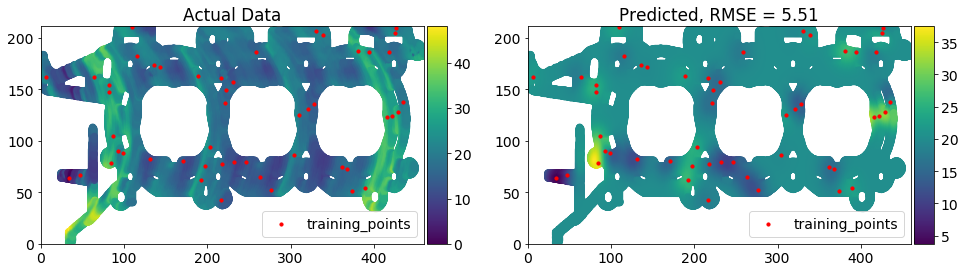

In [43]:
f, axarr = plt.subplots(1,2,figsize = (16,4))
ax1, ax2 = axarr[0], axarr[1]

z1 = ax1.scatter(X_test_random[:,0], X_test_random[:,1], c = y_test_random)
add_colorbar(z1)
ax1.scatter(X_train_random[:,0], X_train_random[:,1], color = 'red', s = 10, label = 'training_points')
ax1.set_xlim([0, df.X.max()])
ax1.set_ylim([0, df.Y.max()])
ax1.set_title('Actual Data')
ax1.legend()

z2 = ax2.scatter(X_test_random[:,0], X_test_random[:,1], c = y_pred_random)
add_colorbar(z2)
ax2.scatter(X_train_random[:,0], X_train_random[:,1], color = 'red', s = 10, label = 'training_points')
ax2.set_xlim([0, df.X.max()])
ax2.set_ylim([0, df.Y.max()])
ax2.set_title('Predicted, RMSE = {:.2f}'.format(RMSE_random))
ax2.legend()

plt.show()

#### Variance

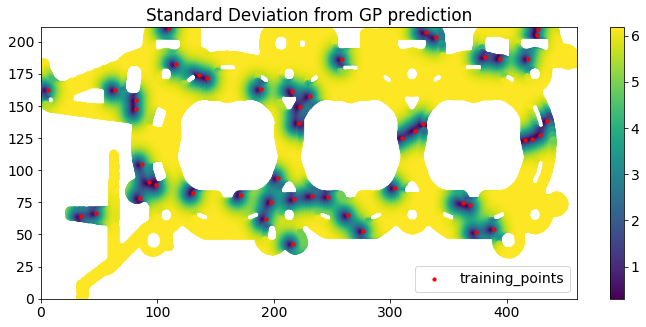

In [44]:
plt.figure(figsize = (12,5))
plt.scatter(X_test_random[:,0], X_test_random[:,1], c = std_random)
plt.colorbar()
plt.scatter(X_train_random[:,0], X_train_random[:,1], color = 'red', s = 10, label = 'training_points')
plt.xlim([0, df.X.max()])
plt.ylim([0, df.Y.max()])
plt.title('Standard Deviation from GP prediction')
plt.legend()
plt.show()

### Sequential Sampling (Entropy approach)

In [24]:
#Generate first 10 points randomly
entropy_train, entropy_test = randomSampling(df, 10)
X_train_entropy, y_train_entropy = entropy_train[:,:-1], entropy_train[:,-1] 
X_test_entropy, y_test_entropy = entropy_test[:,:-1], entropy_test[:,-1]

#For the remaining 40 points, we use sequential sampling
for j in range(40):
    RMSE_entropy, _, y_pred_entropy, std_entropy = gaussianProcess(X_train_entropy, y_train_entropy,  X_test_entropy, y_test_entropy)
    
    #Add jth point to the training set from test set
    maxidx = np.argmax(std_entropy)
    X_train_entropy = np.append(X_train_entropy, X_test_entropy[maxidx].reshape(1,-1) , axis = 0)
    y_train_entropy = np.append(y_train_entropy, y_test_entropy[maxidx])
    
    #Remove that point from test set, predicted set, and variance
    X_test_entropy = np.delete(X_test_entropy, maxidx, 0)
    y_test_entropy = np.delete(y_test_entropy, maxidx)
    y_pred_entropy = np.delete(y_pred_entropy, maxidx)
    std_entropy = np.delete(std_entropy, maxidx)

#### Response Surface

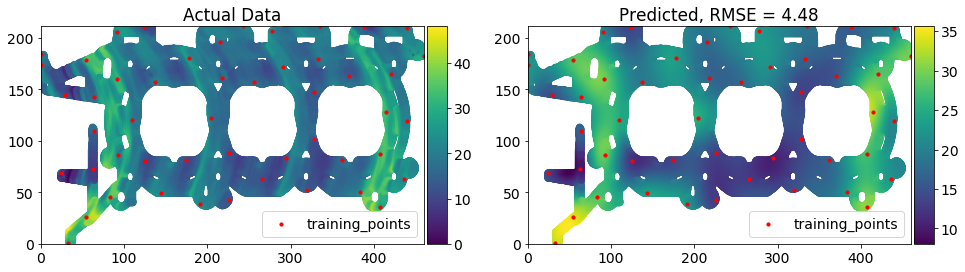

In [25]:
f, axarr = plt.subplots(1,2,figsize = (16,4))
ax1, ax2 = axarr[0], axarr[1]

z1 = ax1.scatter(X_test_entropy[:,0], X_test_entropy[:,1], c = y_test_entropy)
add_colorbar(z1)
ax1.scatter(X_train_entropy[:,0], X_train_entropy[:,1], color = 'red', s = 10, label = 'training_points')
ax1.set_xlim([0, df.X.max()])
ax1.set_ylim([0, df.Y.max()])
ax1.set_title('Actual Data')
ax1.legend()

z2 = ax2.scatter(X_test_entropy[:,0], X_test_entropy[:,1], c = y_pred_entropy)
add_colorbar(z2)
ax2.scatter(X_train_entropy[:,0], X_train_entropy[:,1], color = 'red', s = 10, label = 'training_points')
ax2.set_xlim([0, df.X.max()])
ax2.set_ylim([0, df.Y.max()])
ax2.set_title('Predicted, RMSE = {:.2f}'.format(RMSE_entropy))
ax2.legend()

plt.show()

#### Variance

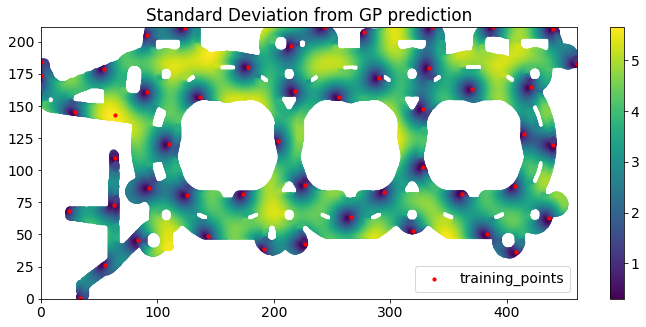

In [26]:
plt.figure(figsize = (12,5))
plt.scatter(X_test_entropy[:,0], X_test_entropy[:,1], c = std_entropy)
plt.colorbar()
plt.scatter(X_train_entropy[:,0], X_train_entropy[:,1], color = 'red', s = 10, label = 'training_points')
plt.xlim([0, df.X.max()])
plt.ylim([0, df.Y.max()])
plt.title('Standard Deviation from GP prediction')
plt.legend()
plt.show()

### Comparison

In [54]:
rmse_random = []
rmse_entropy = []
std_random_averaged = []
std_entropy_averaged = []

for i in range(20):
    #Generate all 50 points randomly
    random_train, random_test = randomSampling(df, 50)
    X_train_random, y_train_random = random_train[:,:-1], random_train[:,-1] 
    X_test_random, y_test_random = random_test[:,:-1], random_test[:,-1]
    
    RMSE_random, _, y_pred_random, std_random = gaussianProcess(X_train_random, y_train_random, X_test_random, y_test_random)
    
    rmse_random.append(RMSE_random)
    std_random_averaged.append(np.mean(std_random))

    #Generate first 10 points randomly
    entropy_train, entropy_test = randomSampling(df, 10)
    X_train_entropy, y_train_entropy = entropy_train[:,:-1], entropy_train[:,-1] 
    X_test_entropy, y_test_entropy = entropy_test[:,:-1], entropy_test[:,-1]
    

    #For the remaining 40 points, we use sequential sampling
    for j in range(40):
        RMSE_entropy, _, y_pred_entropy, std_entropy = gaussianProcess(X_train_entropy, y_train_entropy,  X_test_entropy, y_test_entropy)

        #Add jth point to the training set from test set
        maxidx = np.argmax(std_entropy)
        X_train_entropy = np.append(X_train_entropy, X_test_entropy[maxidx].reshape(1,-1) , axis = 0)
        y_train_entropy = np.append(y_train_entropy, y_test_entropy[maxidx])

        #Remove that point from test set, predicted set, and variance
        X_test_entropy = np.delete(X_test_entropy, maxidx, 0)
        y_test_entropy = np.delete(y_test_entropy, maxidx)
        y_pred_entropy = np.delete(y_pred_entropy, maxidx)
        std_entropy = np.delete(std_entropy, maxidx)
    
    rmse_entropy.append(RMSE_entropy)
    std_entropy_averaged.append(np.mean(std_entropy))

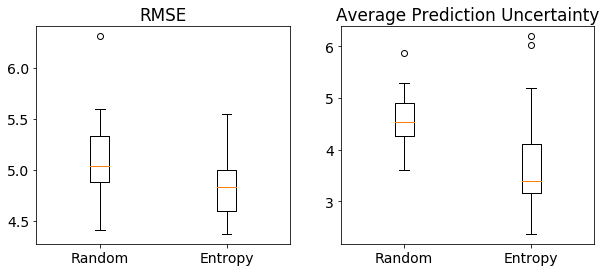

In [55]:
fig, axarr = plt.subplots(1,2,figsize = (10, 4))
ax1, ax2 = axarr[0], axarr[1]

ax1.boxplot([rmse_random, rmse_entropy])
ax1.set_xticklabels(['Random', 'Entropy'])
ax1.set_title('RMSE')

ax2.boxplot([std_random_averaged, std_entropy_averaged])
ax2.set_xticklabels(['Random', 'Entropy'])
ax2.set_title('Average Prediction Uncertainty')

#plt.savefig('sampling_boxplots.jpg', dpi = 400, bbox_inches = 'tight')

plt.show()

#### Response Surface Comparison

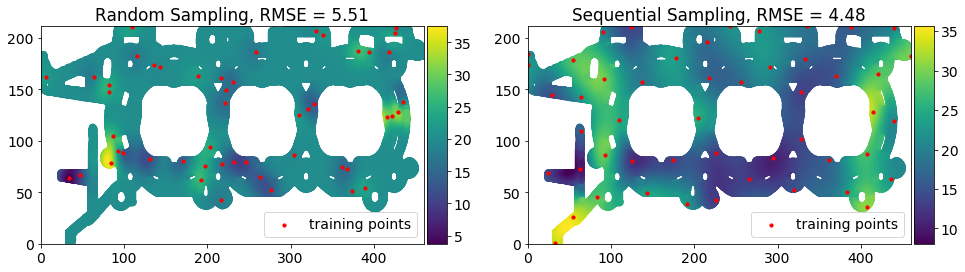

In [49]:
f, axarr = plt.subplots(1,2,figsize = (16,4))
ax1, ax2 = axarr[0], axarr[1]

z1 = ax1.scatter(X_test_random[:,0], X_test_random[:,1], c = y_pred_random)
add_colorbar(z1)
ax1.scatter(X_train_random[:,0], X_train_random[:,1], color = 'red', s = 10, label = 'training points')
ax1.set_xlim([0, df.X.max()])
ax1.set_ylim([0, df.Y.max()])
ax1.set_title('Random Sampling, RMSE = {:.2f}'.format(RMSE_random))
ax1.legend()

z2 = ax2.scatter(X_test_entropy[:,0], X_test_entropy[:,1], c = y_pred_entropy)
add_colorbar(z2)
ax2.scatter(X_train_entropy[:,0], X_train_entropy[:,1], color = 'red', s = 10, label = 'training points')
ax2.set_xlim([0, df.X.max()])
ax2.set_ylim([0, df.Y.max()])
ax2.set_title('Sequential Sampling, RMSE = {:.2f}'.format(RMSE_entropy))
ax2.legend()

#plt.savefig('sampling_rmse.jpg', dpi = 400, bbox_inches = 'tight')

plt.show()

#### Variance Comparison

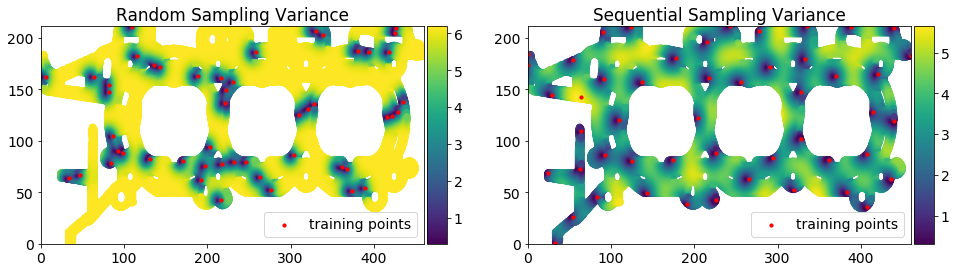

In [50]:
f, axarr = plt.subplots(1,2,figsize = (16,4))
ax1, ax2 = axarr[0], axarr[1]

z1 = ax1.scatter(X_test_random[:,0], X_test_random[:,1], c = std_random)
add_colorbar(z1)
ax1.scatter(X_train_random[:,0], X_train_random[:,1], color = 'red', s = 10, label = 'training points')
ax1.set_xlim([0, df.X.max()])
ax1.set_ylim([0, df.Y.max()])
ax1.set_title('Random Sampling Variance')
ax1.legend()

z2 = ax2.scatter(X_test_entropy[:,0], X_test_entropy[:,1], c = std_entropy)
add_colorbar(z2)
ax2.scatter(X_train_entropy[:,0], X_train_entropy[:,1], color = 'red', s = 10, label = 'training points')
ax2.set_xlim([0, df.X.max()])
ax2.set_ylim([0, df.Y.max()])
ax2.set_title('Sequential Sampling Variance')
ax2.legend()

#plt.savefig('sampling_variance.jpg', dpi = 400, bbox_inches = 'tight')

plt.show()